In [1]:
"""
This script computes the LPIPS, SSIM and ORB metrics betweeen corresponding image pairs
1- Experimental images
2- Diffusion conditioned on simulated images

"""

'\nThis script computes the LPIPS, SSIM and ORB metrics betweeen corresponding image pairs\n1- Experimental images\n2- Diffusion conditioned on simulated images\n\n'

In [2]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import os
import lpips
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import lpips
import cv2


In [3]:

# Paths to three folders
exp_folder = '/hpc/group/youlab/ks723/storage/Exp_images/Final_Test_set_preprocess_v3'
sim_folder = '/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Final_Test_set_v3'
pred_folder = '/hpc/dctrl/ks723/inference/Generated_202552_327_simtoexp_v3'

def load_image_batch(folder, exts=(".tif", ".png")):
    # listdir + filter + sort
    files = sorted(f for f in os.listdir(folder) if f.lower().endswith(exts))
    to_tensor = ToTensor()
    imgs = []
    for fname in files:
        path = os.path.join(folder, fname)
        img = Image.open(path).convert("RGB")
        # Resize to 256x256
        img = img.resize((256, 256), Image.LANCZOS)
        imgs.append(to_tensor(img))
    return torch.stack(imgs)  # [N, C, H, W]

# load batches
exp_images  = load_image_batch(exp_folder)
sim_images  = load_image_batch(sim_folder)
pred_images = load_image_batch(pred_folder)



In [4]:
"""Sanity check, just display some images for experimental, simulation and prediction images with SSIM comparisions"""

def tensor_to_pil_v2(tensor):
    tensor = tensor.permute(1, 2, 0)  # Convert to (height, width, channels)
    img = (tensor.cpu().numpy() * 255).astype('uint8')
    return Image.fromarray(img.squeeze())

def compute_ssim_high_precision(original_images, reconstructed_images):
    ssim_values = []
    batch_size = original_images.shape[0]

    for i in range(batch_size):
        # Convert tensors to numpy arrays
        original = original_images[i].cpu().numpy()  # Shape: [channels, height, width]
        reconstructed = reconstructed_images[i].cpu().numpy()

        # Ensure images are in the range [0, 1]
        original = np.clip(original, 0, 1)
        reconstructed = np.clip(reconstructed, 0, 1)

        # Convert to [height, width, channels]
        original = np.transpose(original, (1, 2, 0))  # Shape: [height, width, channels]
        reconstructed = np.transpose(reconstructed, (1, 2, 0))

        # Convert reconstructed RGB image to grayscale using standard luminance formula
        if reconstructed.shape[2] == 3:
            reconstructed_gray = np.dot(reconstructed[..., :3], [0.2989, 0.5870, 0.1140])
        else:
            reconstructed_gray = reconstructed.squeeze(axis=2)

        # Ensure original image is grayscale
        if original.shape[2] == 1:
            original_gray = original.squeeze(axis=2)
        else:
            original_gray = np.dot(original[..., :3], [0.2989, 0.5870, 0.1140])

        # Compute SSIM
        ssim_index = ssim(original_gray, reconstructed_gray, data_range=1.0)
        ssim_values.append(ssim_index)

    return ssim_values




def display_images_with_ssim(reference_images, comparison_images, num_samples=3):
    # Compute SSIM values using high-precision data
    ssim_values = compute_ssim_high_precision(reference_images, comparison_images)

    fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 3, 8))
    fig.subplots_adjust(hspace=0.3, wspace=0.5)

    for i in range(num_samples):
        # Get the reference and comparison images
        ref_image = reference_images[i].cpu().numpy()  # Shape: [C, H, W] or [H, W]
        comp_image = comparison_images[i].cpu().numpy()  # Shape: [C, H, W]

        print(f"Sample {i}: ref_image.shape = {ref_image.shape}, comp_image.shape = {comp_image.shape}")

        # Handle the reference image (ground truth)
        if ref_image.ndim == 3 and ref_image.shape[0] == 1:
            # Grayscale image, squeeze the channel dimension
            ref_image_disp = ref_image.squeeze(0)  # Shape: [H, W]
        elif ref_image.ndim == 3:
            # If the image has more channels, convert to grayscale
            ref_image_disp = np.transpose(ref_image, (1, 2, 0))
            ref_image_disp = np.dot(ref_image_disp[..., :3], [0.2989, 0.5870, 0.1140])
        elif ref_image.ndim == 2:
            # Already a 2D grayscale image
            ref_image_disp = ref_image  # Shape: [H, W]
        else:
            raise ValueError(f"Unexpected ref_image shape: {ref_image.shape}")

        # Handle the comparison image (predicted image)
        if comp_image.ndim == 3 and comp_image.shape[0] == 3:
            # Transpose to [H, W, C]
            comp_image_disp = np.transpose(comp_image, (1, 2, 0))
            # Convert RGB to grayscale
            comp_image_disp = np.dot(comp_image_disp[..., :3], [0.2989, 0.5870, 0.1140])
        elif comp_image.ndim == 3 and comp_image.shape[0] == 1:
            comp_image_disp = comp_image.squeeze(0)  # Shape: [H, W]
        elif comp_image.ndim == 2:
            comp_image_disp = comp_image  # Shape: [H, W]
        else:
            raise ValueError(f"Unexpected comp_image shape: {comp_image.shape}")

        # Triplicate the single-channel array along the third dimension
        
        image_o=tensor_to_pil_v2(reference_images[i,:,:,:])
        image_p= tensor_to_pil_v2(comparison_images[i,:,:,:].to("cpu"))


        # # Triplicate the single-channel array along the third dimension
        # image_o_3channel = np.stack([image_o] * 3, axis=-1)
      
        # abs_error = np.abs(np.array(image_o_3channel, dtype=np.float32) - np.array(image_p, dtype=np.float32))
        # abs_error_image = Image.fromarray(abs_error.astype(np.uint8))
        
        

        # Display the reference image
        axes[0, i].imshow(ref_image_disp, cmap='gray')
        axes[0, i].axis('off')
        # axes[0, i].set_title('Ground Truth')

        # Display the comparison image
        axes[1, i].imshow(comp_image_disp, cmap='gray')
        axes[1, i].axis('off')
        # axes[1, i].set_title('Predicted Image')


        #     # Display the comparison image
        # axes[2, i].imshow(abs_error_image, cmap='gray')
        # axes[2, i].axis('off')
        # # axes[1, i].set_title('Predicted Image')


        # Display the SSIM score
        axes[2, i].text(0.5, 0.5, f'{ssim_values[i]:.3f}',
                        ha='center', va='center', fontsize=30)
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()



Sample 0: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 1: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 2: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 3: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 4: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)


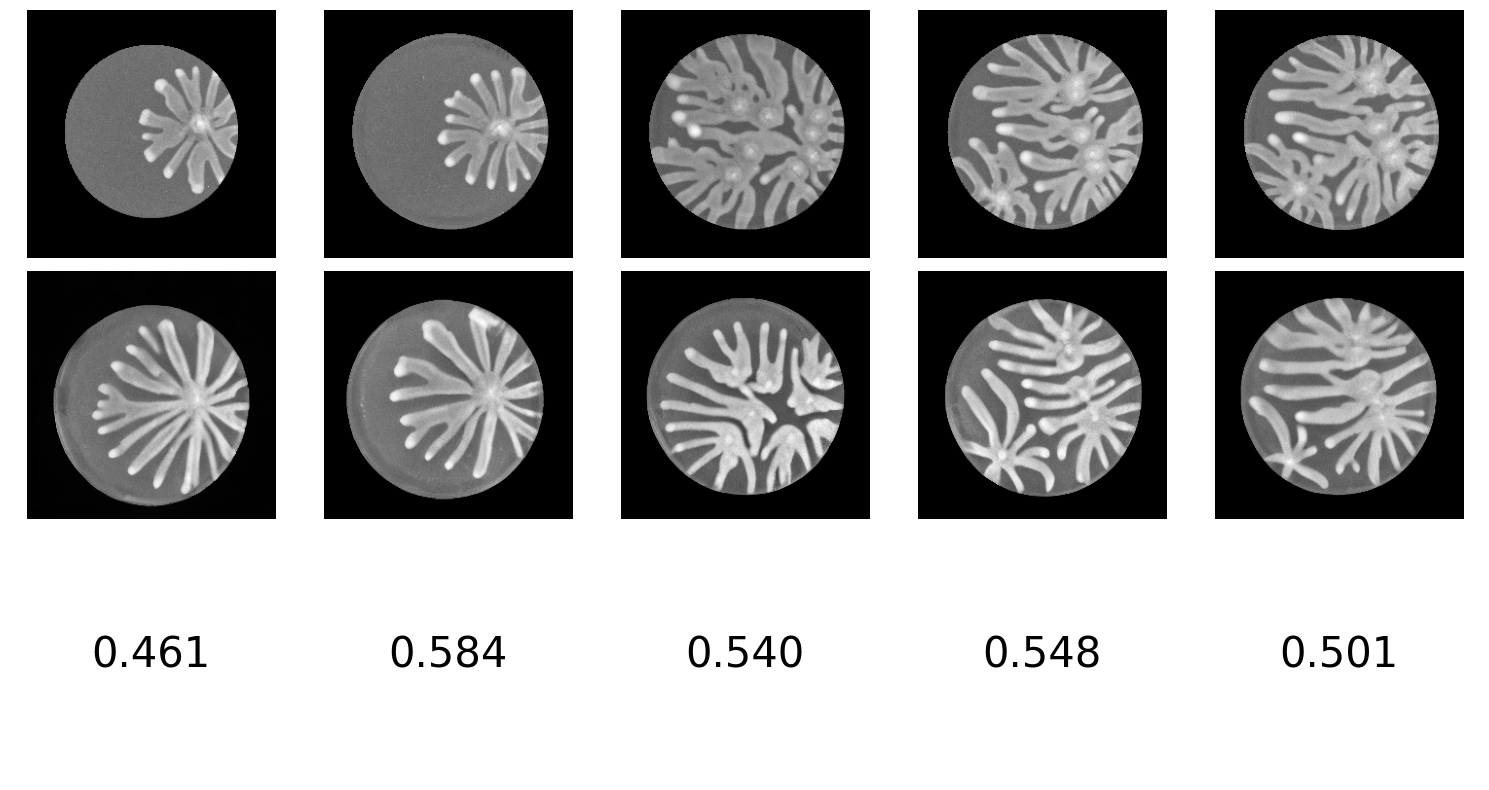

In [5]:
# comparision for experiment and prediction images
selected_indices=[4,5,2,6,7]
display_images_with_ssim(exp_images[selected_indices], pred_images[selected_indices], num_samples=5)

Sample 0: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 1: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 2: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 3: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)
Sample 4: ref_image.shape = (3, 256, 256), comp_image.shape = (3, 256, 256)


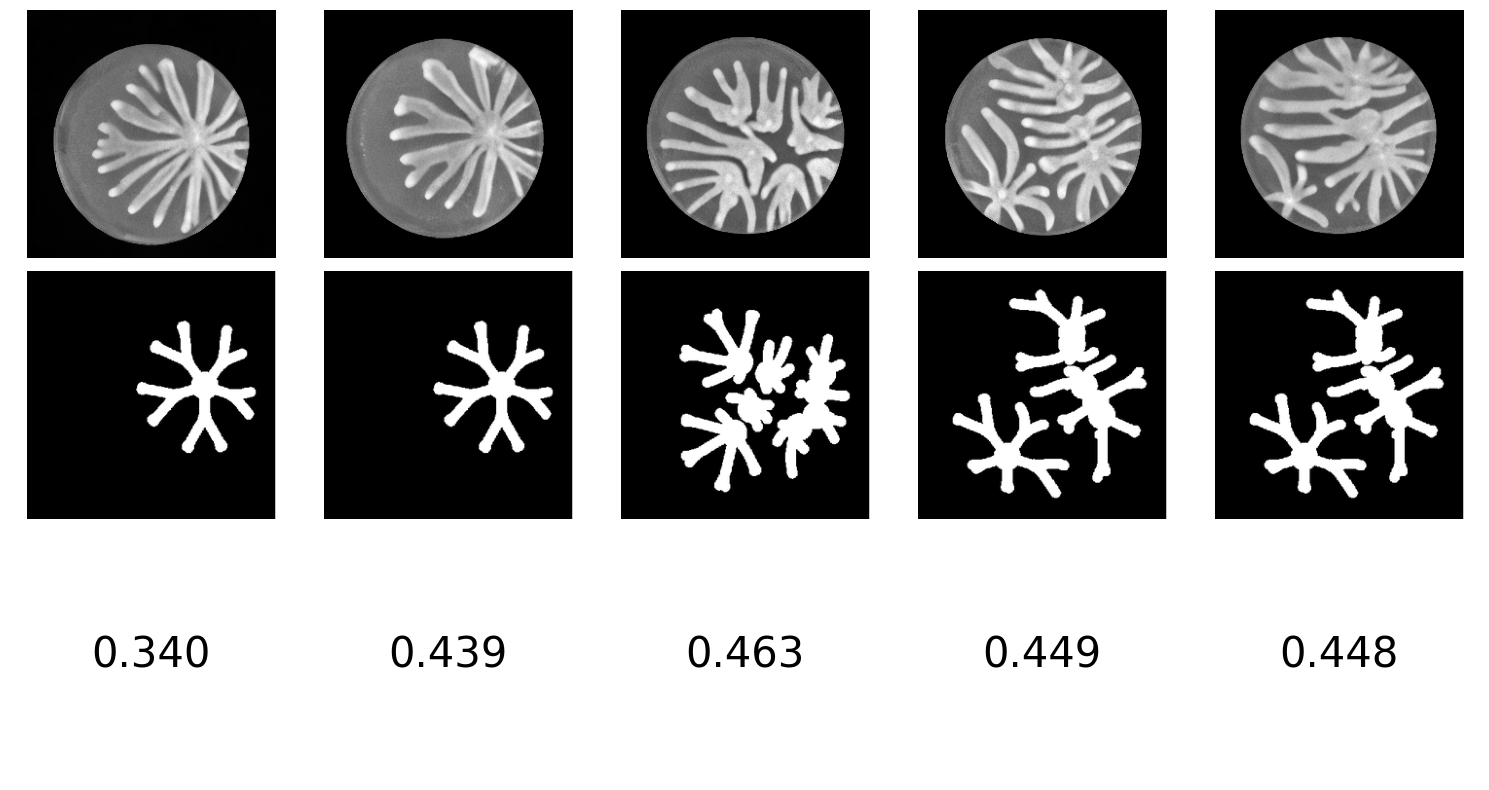

In [6]:
# comparision for prediction and simulation images
selected_indices=[4,5,2,6,7]
display_images_with_ssim(pred_images[selected_indices], sim_images[selected_indices], num_samples=5)

In [7]:
"""Setup for LPIPS, SSIM and ORB calculations in batches"""

device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lpips_model = lpips.LPIPS(net='vgg').to(device).eval()
orb         = cv2.ORB_create()
bf          = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)


def calculate_lpips_score_batch(imgs1: torch.Tensor, imgs2: torch.Tensor) -> np.ndarray:
    """
    imgs1, imgs2: [B, C, H, W] in [0,1]
    returns: np.ndarray of shape [B] with LPIPS scores
    """
    if imgs1 is None or imgs2 is None:
        return np.full((0,), np.nan)

    scores = []
    for img1, img2 in zip(imgs1, imgs2):
        # bring to [1,C,H,W] on correct device
        x1 = img1.unsqueeze(0).to(device).float()
        x2 = img2.unsqueeze(0).to(device).float()

        # if single‐channel, repeat to 3
        if x1.size(1) == 1:
            x1 = x1.repeat(1, 3, 1, 1)
            x2 = x2.repeat(1, 3, 1, 1)

        # resize exactly as your PIL‐Resize((256,256))
        x1 = F.interpolate(x1, size=(256, 256), mode='bilinear', align_corners=False)
        x2 = F.interpolate(x2, size=(256, 256), mode='bilinear', align_corners=False)

        # normalize to [-1,1] if currently in [0,1]
        if x1.min() >= 0 and x1.max() <= 1:
            x1 = x1 * 2 - 1
            x2 = x2 * 2 - 1

        with torch.no_grad():
            score = lpips_model(x1, x2).item()
        scores.append(score)

    return np.array(scores)


def calculate_orb_similarity_batch(imgs1: torch.Tensor, imgs2: torch.Tensor) -> np.ndarray:
    """
    imgs1, imgs2: [B, C, H, W] in [0,1]
    returns: np.ndarray of shape [B] with ORB match‐fraction scores
    """
    if imgs1 is None or imgs2 is None:
        return np.full((0,), np.nan)

    scores = []
    for img1, img2 in zip(imgs1, imgs2):
        # to H×W×C uint8
        arr1 = (img1.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
        arr2 = (img2.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

        # convert to gray exactly as PIL.convert('L')
        gray1 = cv2.cvtColor(arr1, cv2.COLOR_RGB2GRAY) if arr1.ndim == 3 else arr1
        gray2 = cv2.cvtColor(arr2, cv2.COLOR_RGB2GRAY) if arr2.ndim == 3 else arr2

        # match shapes
        if gray2.shape != gray1.shape:
            gray2 = cv2.resize(gray2, (gray1.shape[1], gray1.shape[0]))

        kp1, des1 = orb.detectAndCompute(gray1, None)
        kp2, des2 = orb.detectAndCompute(gray2, None)
        if des1 is None or des2 is None or not kp1 or not kp2:
            scores.append(0.0)
        else:
            matches = bf.match(des1, des2)
            scores.append(len(matches) / max(len(kp1), len(kp2)))

    return np.array(scores)


def calculate_ssim_batch(original_images: torch.Tensor,
                       reconstructed_images: torch.Tensor) -> np.ndarray:
    """
    original_images, reconstructed_images: [B, C, H, W] in [0,1]
    returns: np.ndarray of shape [B] with SSIM scores
    """
    B, C, H, W = original_images.shape
    scores = []

    for i in range(B):
        orig = original_images[i].cpu().numpy()       # [C, H, W]
        recon = reconstructed_images[i].cpu().numpy()

        # clip to [0,1]
        orig = np.clip(orig, 0, 1)
        recon = np.clip(recon, 0, 1)

        # to [H, W, C]
        orig = np.transpose(orig, (1, 2, 0))
        recon = np.transpose(recon, (1, 2, 0))

        # RGB → gray
        if orig.shape[2] == 3:
            orig_gray = np.dot(orig[..., :3], [0.2989, 0.5870, 0.1140])
        else:
            orig_gray = orig.squeeze(axis=2)

        if recon.shape[2] == 3:
            recon_gray = np.dot(recon[..., :3], [0.2989, 0.5870, 0.1140])
        else:
            recon_gray = recon.squeeze(axis=2)

        score = ssim(orig_gray, recon_gray, data_range=1.0)
        scores.append(score)

    return np.array(scores)





Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


In [8]:
# compute LPIPS
lpips_genAI=calculate_lpips_score_batch(exp_images,pred_images)
lpips_sim=calculate_lpips_score_batch(exp_images,sim_images)
lpips_simgenAI=calculate_lpips_score_batch(sim_images,pred_images)

In [9]:
# compute ORB
orb_similarity_genAI=calculate_orb_similarity_batch(exp_images,pred_images)
orb_similarity_sim=calculate_orb_similarity_batch(exp_images,sim_images)
orb_similarity_simgenAI=calculate_orb_similarity_batch(sim_images,pred_images)

In [10]:
# compute SSIM
ssim_similarity_genAI=calculate_ssim_batch(exp_images,pred_images)
ssim_similarity_sim=calculate_ssim_batch(exp_images,sim_images)
ssim_similarity_simgenAI=calculate_ssim_batch(sim_images,pred_images)

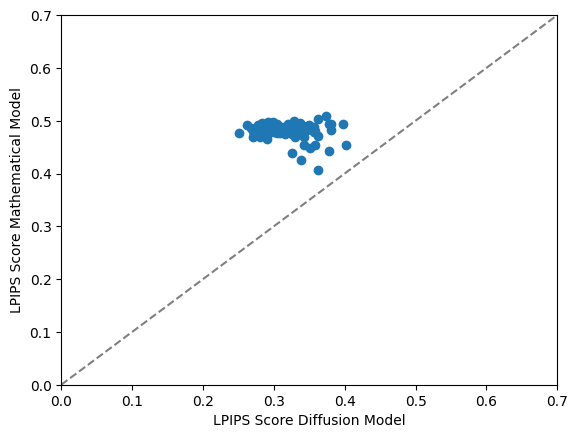

In [11]:
"""These are not in the paper, only to see the distribution of the scores"""
# visualize LPIPS distribution
plt.scatter(lpips_genAI,lpips_sim)

x = np.linspace(0, 0.7, 100)
# Now add y = x line
plt.plot(x, x, color='gray', linestyle='--', label='y = x')

plt.xlabel("LPIPS Score Diffusion Model")
plt.ylabel("LPIPS Score Mathematical Model")
plt.xlim([0,0.7])
plt.ylim([0,0.7])
plt.show()



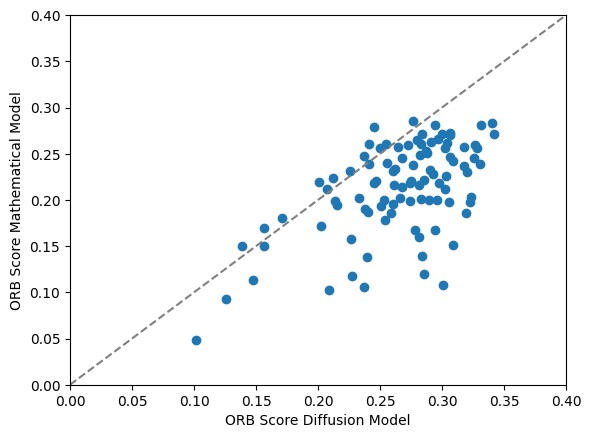

In [12]:
# visualize ORB distribution
plt.scatter(orb_similarity_genAI,orb_similarity_sim)
x = np.linspace(0, 0.5, 100)
# Now add y = x line
plt.plot(x, x, color='gray', linestyle='--', label='y = x')

plt.xlabel("ORB Score Diffusion Model")
plt.ylabel("ORB Score Mathematical Model")
plt.xlim([0,0.4])
plt.ylim([0,0.4])
plt.show()


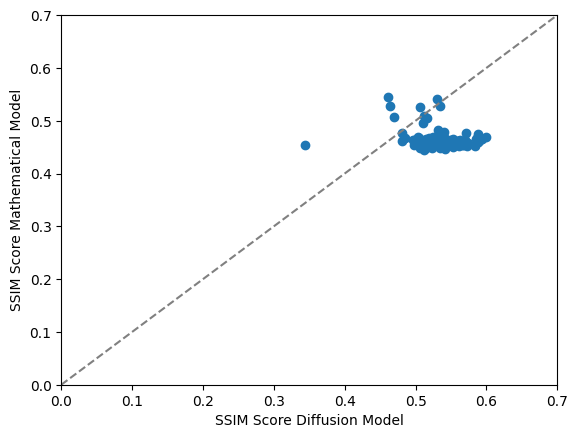

In [13]:
# visualize SSIM distribution
plt.scatter(ssim_similarity_genAI,ssim_similarity_sim)
x = np.linspace(0, 1, 100)
# Now add y = x line
plt.plot(x, x, color='gray', linestyle='--', label='y = x')

plt.xlabel("SSIM Score Diffusion Model")
plt.ylabel("SSIM Score Mathematical Model")
plt.xlim([0,0.7])
plt.ylim([0,0.7])
plt.show()


In [14]:
# Mean+-std of the scores

def print_summary_statistics(scores, name):
    mean_score = np.nanmean(scores)
    std_score = np.nanstd(scores)
    print(f"{name} - Mean: {mean_score:.4f}, Std: {std_score:.4f}")

print_summary_statistics(lpips_sim, "LPIPS Exp and Sim")
print_summary_statistics(ssim_similarity_sim, "SSIM Exp and Sim")
print_summary_statistics(orb_similarity_sim, "ORB Exp and Sim")

print_summary_statistics(lpips_genAI, "LPIPS Exp and Pred")
print_summary_statistics(ssim_similarity_genAI, "SSIM Exp and Pred")
print_summary_statistics(orb_similarity_genAI, "ORB Exp and Pred")

print_summary_statistics(lpips_simgenAI, "LPIPS Sim and Pred")
print_summary_statistics(ssim_similarity_simgenAI, "SSIM Sim and Pred")
print_summary_statistics(orb_similarity_simgenAI, "ORB Sim and Pred")


LPIPS Exp and Sim - Mean: 0.4814, Std: 0.0152
SSIM Exp and Sim - Mean: 0.4667, Std: 0.0192
ORB Exp and Sim - Mean: 0.2130, Std: 0.0496
LPIPS Exp and Pred - Mean: 0.3148, Std: 0.0327
SSIM Exp and Pred - Mean: 0.5312, Std: 0.0359
ORB Exp and Pred - Mean: 0.2661, Std: 0.0483
LPIPS Sim and Pred - Mean: 0.4952, Std: 0.0096
SSIM Sim and Pred - Mean: 0.4420, Std: 0.0340
ORB Sim and Pred - Mean: 0.2128, Std: 0.0422


In [ ]:
# Plot each image comparision and save them to a folder
# for LPIPS, SSIM and ORB scores

def save_image_comparisons(reference_images, comparison_images, ssim_scores, lpips_scores, orb_scores, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    
    for i in range(len(reference_images)):
        ref_image = tensor_to_pil_v2(reference_images[i])
        comp_image = tensor_to_pil_v2(comparison_images[i])
        
        # Create a  1 row, 3 column plot in matplotlib
        fig, axes = plt.subplots(1, 3, figsize=(15, 5),layout='constrained')
        fig.subplots_adjust(hspace=0.3, wspace=0.5)
        axes[0].imshow(ref_image, cmap='gray')
        axes[0].axis('off')
        axes[0].set_title('Ground Truth')
        axes[1].imshow(comp_image, cmap='gray') 
        axes[1].axis('off')
        axes[1].set_title('Predicted Image')

        axes[2].text(0.5, 0.5, f'SSIM: {ssim_scores[i]:.3f}\nLPIPS: {lpips_scores[i]:.3f}\nORB: {orb_scores[i]:.3f}',
                        ha='center', va='center', fontsize=12)
        axes[2].axis('off') 
        axes[2].set_title('Scores')
        

        # Save the figure
        output_path = os.path.join(output_folder, f'Comparison_{i}.png')
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1)
        # close figure to save space
        plt.close(fig)



# Save comparisons for Exp vs Pred
task='ExpvsPred'
save_image_comparisons(exp_images, pred_images, ssim_similarity_genAI, lpips_genAI, orb_similarity_genAI, f'/hpc/dctrl/ks723/inference/Comparisions_{task}')
task='ExpvsSim'
# Save comparisons for Exp vs Sim
save_image_comparisons(exp_images, sim_images, ssim_similarity_sim, lpips_sim, orb_similarity_sim, f'/hpc/dctrl/ks723/inference/Comparisions_{task}')
task='SimvsPred'
# Save comparisons for Sim vs Pred
save_image_comparisons(sim_images, pred_images, ssim_similarity_simgenAI, lpips_simgenAI, orb_similarity_simgenAI, f'/hpc/dctrl/ks723/inference/Comparisions_{task}')



/tmp/ipykernel_3252286/2223058643.py:13: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.3, wspace=0.5)
